# Modelling a COPD ward

The simplest model using the data available to us is an $M|M|c$ queuing model. In this model, the following assumptions are made:

1. Interarrival and service times of patients are each exponential with some mean.
2. There are $c$ servers available to arriving patients at a single node representing the overall resource availability at the hospital.
3. There is no queue capacity.
4. A first-in first-out service policy is implemented.

### Choosing the distributions

#### Arrivals

Each group of patients has its own arrival distribution. The parameter of this distribution is taken to be the reciprocal of the mean interarrival times for that group.

#### Services (derived from responses)

Like arrivals, each group of patients has its own service time distribution. This will be calculated approximately via the length of a patient's stay. Technically, length of stay is the total time spent in the system, i.e. the response time. Without full details of process order and idle periods during a spell, we will consider the mean service time, $\frac{1}{\mu}$, to be proportional to the mean total system time, $\frac{1}{\phi}$, such that:

$$ \mu = p \phi $$

where $p \in (0, 1]$ is some parameter to be determined for each group.

### Determining parameters

As the full details of how the patients move through the hospital system, and the details of the system itself, are unknown, an appropriate number of servers $c$ must be found as well as $p$.

In order to estimate "good" values of each $p$ and the value of $c$, the system will be simulated using a number of parameter sets. Then the total time distribution will be compared with that in the available data via the (first) Wasserstein distance. This distance measures the approximate "minimal work" required to move between two probability distributions where "work" can be loosely defined as the product of how much of the distribution's mass must be to be moved with the distance it must be moved.

More formally, the Wasserstein distance between two probability distributions $f$ and $g$ is defined as:

$$ W(f, g) = \int_{-\infty}^{\infty} \left\vert F - G \right\vert $$

where $F$ and $G$ are the CDFs of $f$ and $g$ respectively [[RGC15]](https://arxiv.org/abs/1509.02237).

Then the parameter set with the smallest distance is taken to be the most appropriate.

In [1]:
import itertools as it
from collections import defaultdict

import ciw
from ciw.dists import Exponential
import dask
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import special, stats

%matplotlib inline
plt.style.use("seaborn-colorblind")


In [2]:
copd = pd.read_csv(
    "../data/copd_clustered.csv", parse_dates=["admission_date", "discharge_date"]
)


The following code gets the number of patients in the hospital system on a given date.

```python
def get_n_patients(data, date):

    patients_in_system_at_date = (
        (data["admission_date"] <= date)
        & (date <= data["discharge_date"])
    )

    return len(data[patients_in_system_at_date])


get_parts = lambda x: (x.year, x.month, x.day)

year, month, day = get_parts(copd["admission_date"].min())
start_date = pd.to_datetime(f"{year}-{month}-{day}")

year, month, day = get_parts(copd["discharge_date"].max())
end_date = pd.to_datetime(f"{year}-{month}-{day + 1}")

system_size = pd.DataFrame(
    {"date": pd.date_range(start=start_date, end=end_date, freq="d")}
)

for intervention, data in copd.groupby("intervention"):
    system_size[intervention] = system_size["date"].apply(lambda date: get_n_patients(data, date))
```

In [3]:
def get_times(diff):

    times = diff.dt.total_seconds().div(24 * 60 * 60, fill_value=0)
    return times

    
def get_queue_params(data, prop, dist=stats.expon):
    """ Get the arrival and service parameters from `data` and the given `prop`. """

    inter_arrivals = (
        data.set_index("admission_date").sort_index().index.to_series().diff()
    )
    interarrival_times = get_times(inter_arrivals)
    lambda_ = np.mean(interarrival_times)

    mean_system_time = np.mean(data["true_los"])
    mu_estimate = mean_system_time * prop

    queue_params = {"arrival": 1 / lambda_, "service": 1 / mu_estimate}

    return queue_params


In [4]:
@dask.delayed
def run_multiple_class_trial(data, column, props, num_servers, seed, max_time=365 * 30):

    ciw.seed(seed)
    all_queue_params = defaultdict(dict)
    for (label, subdata), service_prop in zip(
        data.groupby(column), props
    ):
        all_queue_params[label] = get_queue_params(subdata, service_prop)

    N = ciw.create_network(
        arrival_distributions={
            f"Class {label}": [Exponential(params["arrival"])]
            for label, params in all_queue_params.items()
        },
        service_distributions={
            f"Class {label}": [Exponential(params["service"])]
            for label, params in all_queue_params.items()
        },
        number_of_servers=[num_servers],
    )

    Q = ciw.Simulation(N)
    Q.simulate_until_max_time(max_time)

    records = Q.get_all_records()
    results = pd.DataFrame(
        [r for r in records if max_time * 0.25 < r.arrival_date < max_time * 0.75]
    )

    results["total_time"] = results["exit_date"] - results["arrival_date"]
    results["service_prop"] = results["customer_class"].apply(lambda x: props[x])
    results["num_servers"] = num_servers
    results["seed"] = seed

    name = "_".join([str(p) for p in props]) + "_" + "_".join([str(num_servers), str(seed)])
    results.to_csv(f"../data/queuing/{name}.csv", index=False)

    distance = stats.wasserstein_distance(results["total_time"], copd["true_los"])
    return (*props, num_servers, seed, distance)


In [5]:
n_clusters = copd["cluster"].nunique()
prop_lims, steps = (0.5, 1), 6
server_lims = (40, 56, 5)
seeds = 1

tasks = (
    run_multiple_class_trial(
        copd, "cluster", props, num_servers, seed
    )
    for props, num_servers, seed in it.product(
        it.product(np.linspace(*prop_lims, steps), repeat=n_clusters),
        range(*server_lims),
        range(seeds),
    )
)

with ProgressBar():
    results = dask.compute(*tasks, scheduler="processes", num_workers=8)

columns = [*(f"p_{i}" for i in range(n_clusters)), "num_servers", "seed", "distance"]
df = pd.DataFrame(results, columns=columns)

df.head()

[########################################] | 100% Completed |  1hr 35min  4.6s


,p_0,p_1,p_2,p_3,num_servers,seed,distance
0,0.5,0.5,0.5,0.5,40,0,3.841400
1,0.5,0.5,0.5,0.5,45,0,3.841400
2,0.5,0.5,0.5,0.5,50,0,3.841400
3,0.5,0.5,0.5,0.5,55,0,3.841400
4,0.5,0.5,0.5,0.6,40,0,3.746463


In [7]:
best = np.argmin(df["distance"].values)

*ps, c, seed, dist = df.iloc[best, :]
ps, c, dist

([1.0, 1.0, 1.0, 0.5], 45.0, 0.9065290813441723)

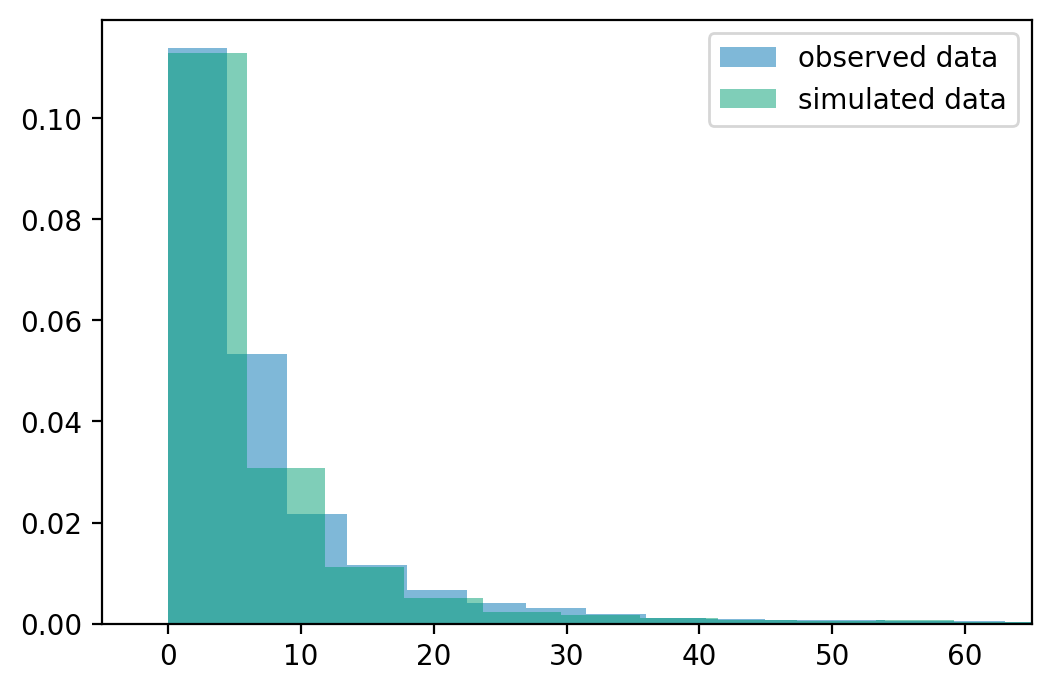

In [9]:
fig, ax = plt.subplots(dpi=200)

name = "_".join([str(p) for p in ps]) + "_" + "_".join([str(int(c)), str(int(seed))])
best_df = pd.read_csv(f"../data/queuing/{name}.csv")

ax.hist(
    copd["true_los"],
    bins=50,
    alpha=0.5,
    density=True,
    label="observed data",
)
ax.hist(best_df["total_time"], bins=50, alpha=0.5, density=True, label="simulated data")

ax.set_xlim(-5, 65)
ax.legend()


In [10]:
worst = np.argmax(df["distance"].values)

*ps, c, seed, dist = df.iloc[worst, :]
ps, c, dist

([0.5, 0.5, 0.5, 0.5], 40.0, 3.841399596874652)

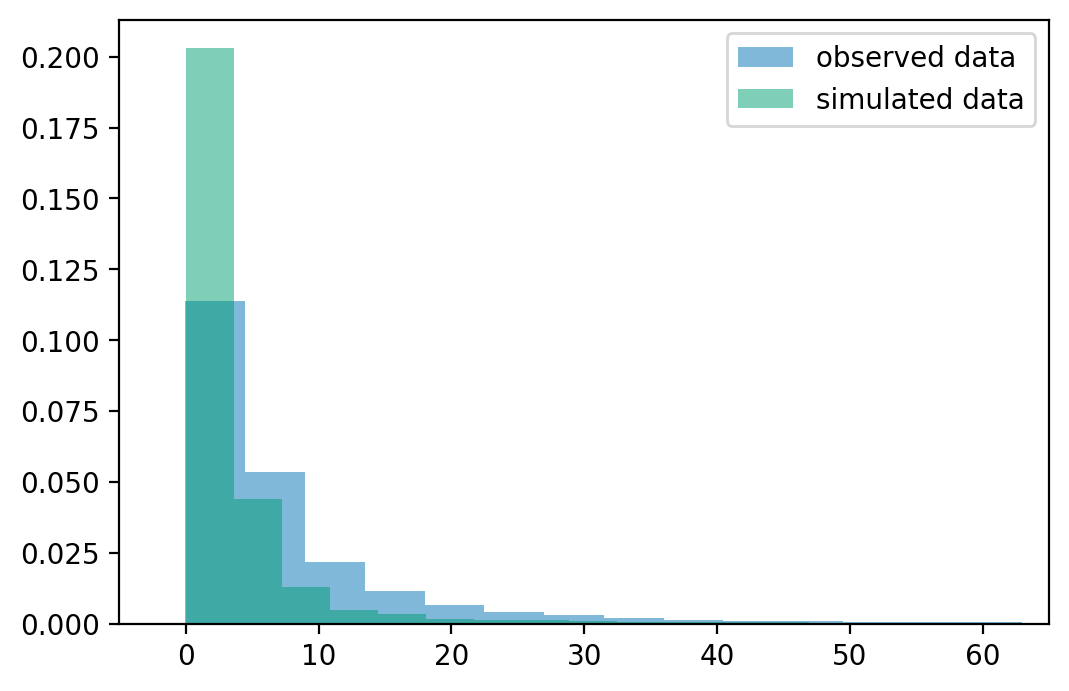

In [11]:
fig, ax = plt.subplots(dpi=200)

name = "_".join([str(p) for p in ps]) + "_" + "_".join([str(int(c)), str(int(seed))])
worst_df = pd.read_csv(f"../data/queuing/{name}.csv")

ax.hist(
    copd["true_los"],
    bins=50,
    alpha=0.5,
    density=True,
    label="observed data",
)
ax.hist(worst_df["total_time"], bins=50, alpha=0.5, density=True, label="simulated data")

ax.set_xlim(-5, 65)
ax.legend()
